In [1]:
%%time
import gzip
import json
import string

import nltk # imports the natural language toolkit
import pandas as pd
import plotly

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
nltk.download('punkt')


CPU times: total: 2.8 s
Wall time: 9.94 s


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\memo_\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
import gensim.downloader as api

# Descargar los embeddings preentrenados
word_vectors = api.load("glove-wiki-gigaword-300")

In [3]:
from tensorflow.keras.optimizers import Adam
import numpy as np
import os
from sklearn.utils import shuffle
from tensorflow.keras.layers import Bidirectional

In [4]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.regularizers import l2 

In [5]:
!pip install contractions

In [6]:
nltk.download('punkt_tab')
import contractions

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\memo_\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [7]:
!pip install spacy
!pip install emoji
!python -m spacy download en_core_web_sm

     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
      --------------------------------------- 0.3/12.8 MB ? eta -:--:--
     - -------------------------------------- 0.5/12.8 MB 1.3 MB/s eta 0:00:10
     - -------------------------------------- 0.5/12.8 MB 1.3 MB/s eta 0:00:10
     -- ------------------------------------- 0.8/12.8 MB 1.2 MB/s eta 0:00:11
     --- ------------------------------------ 1.0/12.8 MB 1.2 MB/s eta 0:00:11
     --- ------------------------------------ 1.0/12.8 MB 1.2 MB/s eta 0:00:11
     --- ------------------------------------ 1.0/12.8 MB 1.2 MB/s eta 0:00:11
     --- ------------------------------------ 1.0/12.8 MB 1.2 MB/s eta 0:00:11
     --- ------------------------------------ 1.0/12.8 MB 1.2 MB/s eta 0:00:11
     --- ------------------------------------ 1.0/12.8 MB 1.2 MB/s eta 0:00:11
     --- ------------------------------------ 1.0/12.8 MB 1.2 MB/s eta 0:00:11
     --- ------------------------------------ 1.0/12.8 MB 1.2 MB/s

In [8]:
import re
import spacy
import emoji
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Descargar stopwords si es la primera vez
nltk.download('stopwords')

# Cargar modelo de spaCy en inglés
nlp = spacy.load("en_core_web_sm")

# Obtener lista de stopwords en inglés
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\memo_\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [92]:
from google.colab import drive
import os
drive.mount('/content/gdrive', force_remount=True)
# Establecer ruta de acceso en dr
import os
print(os.getcwd())
os.chdir("/content/gdrive/My Drive")

ModuleNotFoundError: No module named 'google.colab'

In [10]:
print("Current Directory:", os.getcwd())

Current Directory: C:\Users\memo_


In [11]:

#data_twitter_train = pd.read_csv("DatasetSarcasmOrig/twitter_train.csv")
#data_twitter_test = pd.read_csv("DatasetSarcasmOrig/twitter_test.csv")
#data_head = pd.read_json("DatasetSarcasmOrig/Sarcasm_Headlines_Dataset.json", lines=True)
#data_headv2 = pd.read_json("DatasetSarcasmOrig/Sarcasm_Headlines_Dataset_v2.json", lines=True)

data_twitter_train = pd.read_csv("twitter_train.csv")
data_twitter_test = pd.read_csv("twitter_test.csv")
data_head = pd.read_json("Sarcasm_Headlines_Dataset.json", lines=True)
data_headv2 = pd.read_json("Sarcasm_Headlines_Dataset_v2.json", lines=True)
data_sarcasm_train = pd.read_csv("data_test_sarcasm.csv")
data_sarcasm_test = pd.read_csv("data_train_sarcasm.csv", low_memory=False)


In [12]:
data_twitter_train['is_sarcastic'] = ((data_twitter_train['class'] == "figurative") | (data_twitter_train['class'] == "sarcasm")).astype(int)
#data_twitter_train = data_twitter_train.drop(columns=['class'])

In [13]:
data_twitter_test['is_sarcastic'] = ((data_twitter_test['class'] == "figurative") | (data_twitter_test['class'] == "sarcasm")).astype(int)
#data_twitter_test = data_twitter_test.drop(columns=['class'])

In [14]:
data_twitter_train = data_twitter_train.rename(columns={'tweets': 'text'})
data_twitter_test = data_twitter_test.rename(columns={'tweets': 'text'})


In [15]:
data_head = data_head.rename(columns={'headline': 'text'})
data_headv2 = data_headv2.rename(columns={'headline': 'text'})
data_head.head()

,article_link,text,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [16]:
data_sarcasm_test = pd.read_csv("data_test_sarcasm.csv")
data_sarcasm_train = pd.read_csv("data_train_sarcasm.csv", low_memory=False)

In [17]:
data_sarcasm_train=data_sarcasm_train[data_sarcasm_train["label"] != "AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA"]

In [18]:
print(data_sarcasm_train["label"].unique())

['0' '1']


In [19]:
print(data_sarcasm_train)

       label                                            comment
0          0                                         NC and NH.
1          0  You do know west teams play against west teams...
2          0  They were underdogs earlier today, but since G...
3          0  This meme isn't funny none of the "new york ni...
4          0                    I could use one of those tools.
...      ...                                                ...
949995     1  oh, how I loved making boot disks on those lov...
949996     1         Yeah, I'm sure that's the only explanation
949997     1  Yes, let's use a courtroom that conforms in no...
949998     1  No, only the government, military, and courts ...
949999     1                 Only until they shoot a black man.

[949999 rows x 2 columns]


In [20]:
data_sarcasm_train = data_sarcasm_train.rename(columns={'label': 'is_sarcastic','comment': 'text'})
data_sarcasm_test = data_sarcasm_test.rename(columns={'label': 'is_sarcastic','comment': 'text'})

In [21]:
data_sarcasm_train['is_sarcastic'] = data_sarcasm_train['is_sarcastic'].astype(int)

In [22]:
data_sarcasm_train[data_sarcasm_train["is_sarcastic"] == 1] 

,is_sarcastic,text
33,1,But they'll have all those reviews!
44,1,wow it is totally unreasonable to assume that ...
45,1,Ho ho ho... But Melania said that there is no ...
66,1,I can't wait until @potus starts a twitter war...
69,1,gotta love the teachers who give exams on the ...
...,...,...
949995,1,"oh, how I loved making boot disks on those lov..."
949996,1,"Yeah, I'm sure that's the only explanation"
949997,1,"Yes, let's use a courtroom that conforms in no..."
949998,1,"No, only the government, military, and courts ..."


In [23]:
print(data_twitter_train['is_sarcastic'].value_counts())
print(data_twitter_train['is_sarcastic'].value_counts(normalize=True))

is_sarcastic
1    41919
0    39489
Name: count, dtype: int64
is_sarcastic
1    0.514925
0    0.485075
Name: proportion, dtype: float64


In [24]:
print(data_twitter_test['is_sarcastic'].value_counts())
print(data_twitter_test['is_sarcastic'].value_counts(normalize=True))

is_sarcastic
1    4149
0    3979
Name: count, dtype: int64
is_sarcastic
1    0.510458
0    0.489542
Name: proportion, dtype: float64


In [25]:
print(data_head['is_sarcastic'].value_counts())
print(data_head['is_sarcastic'].value_counts(normalize=True))

is_sarcastic
0    14985
1    11724
Name: count, dtype: int64
is_sarcastic
0    0.561047
1    0.438953
Name: proportion, dtype: float64


In [26]:
print(data_headv2['is_sarcastic'].value_counts())
print(data_headv2['is_sarcastic'].value_counts(normalize=True))

is_sarcastic
0    14985
1    13634
Name: count, dtype: int64
is_sarcastic
0    0.523603
1    0.476397
Name: proportion, dtype: float64


In [27]:
print(data_sarcasm_train['is_sarcastic'].value_counts())
print(data_sarcasm_train['is_sarcastic'].value_counts(normalize=True))

is_sarcastic
0    478451
1    471548
Name: count, dtype: int64
is_sarcastic
0    0.503633
1    0.496367
Name: proportion, dtype: float64


In [28]:
print(data_sarcasm_test['is_sarcastic'].value_counts())
print(data_sarcasm_test['is_sarcastic'].value_counts(normalize=True))

is_sarcastic
1    33865
0    26961
Name: count, dtype: int64
is_sarcastic
1    0.556752
0    0.443248
Name: proportion, dtype: float64


In [29]:
# Separar features (X) y etiquetas (y)
# Concatenar correctamente las columnas "text"
x = pd.concat([data_twitter_train["text"],
               data_twitter_test["text"],
               data_head["text"],
               data_headv2["text"],
              data_sarcasm_train['text'],
              data_sarcasm_test['text']], ignore_index=True)

# Concatenar correctamente las etiquetas "is_sarcastic"
y = pd.concat([data_twitter_train["is_sarcastic"],
               data_twitter_test["is_sarcastic"],
               data_head["is_sarcastic"],
               data_headv2["is_sarcastic"],
              data_sarcasm_train['is_sarcastic'],
              data_sarcasm_test['is_sarcastic']], ignore_index=True)

In [30]:
x, y = shuffle(x, y, random_state=42)

In [31]:
print(y)

14132     1
802313    1
338450    1
104149    0
707711    0
         ..
110268    1
259178    1
131932    1
671155    0
121958    1
Name: is_sarcastic, Length: 1155689, dtype: int64


In [32]:
print(y.value_counts())
print(y.value_counts(normalize=True))

is_sarcastic
0    578850
1    576839
Name: count, dtype: int64
is_sarcastic
0    0.50087
1    0.49913
Name: proportion, dtype: float64


In [33]:
def clean_text(text):

    # Eliminar menciones (@usuario)
    text = re.sub(r'@\w+', '', text)

    # Eliminar URLs
    text = re.sub(r'https?://\S+|www\.\S+|t\.co/\S+', '', text)

    # Sustituir emojis por palabras
    text = emoji.demojize(text)

    # Eliminar caracteres especiales y números
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    text = re.sub(r'\bhttps?\b', '', text)

    return text

In [34]:
# Función para eliminar stopwords
def remove_stopwords(text):
    # Convertir a minúsculas
    text = text.lower()
    #changes contractions to extend form.- don't to do not
    text = contractions.fix(text)
    words = word_tokenize(text)  # Tokenizar
    filtered_text = " ".join([word for word in words if word.lower() not in stop_words])  # Filtrar stopwords
    return filtered_text

In [35]:
def remove_hashtags(text):
    text = re.sub(r'#\w+', '', text)  # Remueve hashtags completos
    return re.sub(r'@\w+', '', text)

In [36]:
x.head()

14132     @notAvantika lmao! in that case I'll prefix #S...
802313    No you're wrong every champion should have the...
338450    Given all the things Ruddock did to secure chi...
104149    what if they held an anti-immigrant party and ...
707711        Nothing like some PT to bring up the spirits.
Name: text, dtype: object

In [37]:
print(x[0])

Be aware  dirty step to get money  #staylight #staywhite  #sarcastic #moralneeded @… https://t.co/Oj6BdyX3WG


In [38]:
x = x.astype(str).apply(remove_hashtags)
x = x.astype(str).apply(remove_stopwords)
x = x.astype(str).apply(clean_text)

In [39]:
x.head()

14132                                     lmao  case prefix
802313    wrong every champion ability way one stronger ...
338450    given things ruddock secure children s future ...
104149                held antiimmigrant party nobody came 
707711                       nothing like pt bring spirits 
Name: text, dtype: object

In [40]:
# Paso 1: Dividir en 80% training y 20% testing (mismo balance de clases en cada conjunto)
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.20, random_state=42, stratify=y  # 🔥 Estratificación aquí
)

# Paso 2: Dividir el training en 80% training y 20% validation (para obtener 80-10-10 total)
x_test, x_val, y_test, y_val = train_test_split(
    x_test, y_test, test_size=0.5, random_state=42, stratify=y_test  # 🔥 Estratificación aquí
)

# Verificar proporciones de clases en cada conjunto
print("Distribución de Clases:")
print("Training:\n", y_train.value_counts(normalize=True))
print("Validation:\n", y_val.value_counts(normalize=True))
print("Testing:\n", y_test.value_counts(normalize=True))
print("Training:\n", y_train.value_counts())
print("Validation:\n", y_val.value_counts())
print("Testing:\n", y_test.value_counts())

Distribución de Clases:
Training:
 is_sarcastic
0    0.50087
1    0.49913
Name: proportion, dtype: float64
Validation:
 is_sarcastic
0    0.50087
1    0.49913
Name: proportion, dtype: float64
Testing:
 is_sarcastic
0    0.50087
1    0.49913
Name: proportion, dtype: float64
Training:
 is_sarcastic
0    463080
1    461471
Name: count, dtype: int64
Validation:
 is_sarcastic
0    57885
1    57684
Name: count, dtype: int64
Testing:
 is_sarcastic
0    57885
1    57684
Name: count, dtype: int64


In [41]:
embedding_dim = 300  # Dimensión de los embeddings GloVe
vocab_size = 30000  # Número máximo de palabras en el vocabulario

# Crear una matriz de embeddings con ceros iniciales
embedding_matrix = np.zeros((vocab_size, embedding_dim))

# Tokenización

tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")  # Token desconocido para palabras desconocidas
tokenizer.fit_on_texts(x_train)  # Aprende el vocabulario

# Convertir texto a secuencias numéricas
X_train_seq = tokenizer.texts_to_sequences(x_train)
X_val_seq = tokenizer.texts_to_sequences(x_val)
X_test_seq = tokenizer.texts_to_sequences(x_test)

# Definir longitud máxima basada en el percentil 98
max_length = int(np.percentile([len(seq) for seq in X_train_seq], 98))  # Longitud máxima óptima para representar el 95% de las palabras

# Aplicar *padding* para normalizar las secuencias
#Se usa pad_sequences() para hacer que todas las secuencias tengan la misma longitud.
#maxlen=max_length: Todas las secuencias tendrán la longitud definida anteriormente.
#padding='post': Los ceros se agregan al final de la secuencia.
#truncating='post': Si una oración es demasiado larga, se recorta al final.
X_train_padded = pad_sequences(X_train_seq, maxlen=max_length, padding='post', truncating='post')
X_val_padded = pad_sequences(X_val_seq, maxlen=max_length, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_length, padding='post', truncating='post')



# Llenar la matriz con los vectores de GloVe
for word, i in tokenizer.word_index.items():
    if i < vocab_size:
        try:
            embedding_matrix[i] = word_vectors[word]
        except KeyError:
            continue  # Si la palabra no está en GloVe, se mantiene en ceros


Epoch 1/20


C:\Users\memo_\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


28893/28893 ━━━━━━━━━━━━━━━━━━━━ 564s 19ms/step - accuracy: 0.6364 - loss: 0.6371 - val_accuracy: 0.6766 - val_loss: 0.5956 - learning_rate: 0.0010
Epoch 2/20
28893/28893 ━━━━━━━━━━━━━━━━━━━━ 557s 19ms/step - accuracy: 0.6880 - loss: 0.5878 - val_accuracy: 0.6834 - val_loss: 0.5878 - learning_rate: 0.0010
Epoch 3/20
28893/28893 ━━━━━━━━━━━━━━━━━━━━ 563s 19ms/step - accuracy: 0.7044 - loss: 0.5681 - val_accuracy: 0.6836 - val_loss: 0.5842 - learning_rate: 0.0010
Epoch 4/20
28893/28893 ━━━━━━━━━━━━━━━━━━━━ 553s 19ms/step - accuracy: 0.7164 - loss: 0.5530 - val_accuracy: 0.6848 - val_loss: 0.5929 - learning_rate: 0.0010
Epoch 5/20
28893/28893 ━━━━━━━━━━━━━━━━━━━━ 535s 19ms/step - accuracy: 0.7277 - loss: 0.5393 - val_accuracy: 0.6859 - val_loss: 0.5878 - learning_rate: 0.0010
Epoch 6/20
28893/28893 ━━━━━━━━━━━━━━━━━━━━ 545s 19ms/step - accuracy: 0.7379 - loss: 0.5260 - val_accuracy: 0.6847 - val_loss: 0.5994 - learning_rate: 0.0010
Epoch 7/20
28893/28893 ━━━━━━━━━━━━━━━━━━━━ 540s 19ms/ste

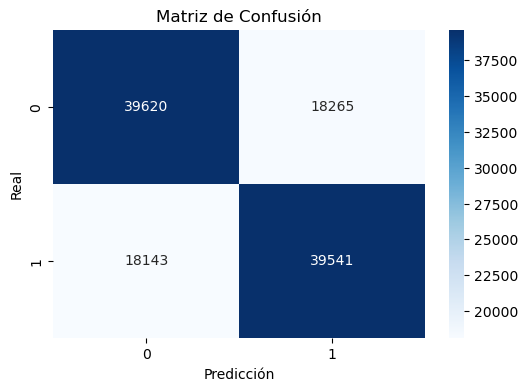


Reporte de Clasificación:
              precision    recall  f1-score   support

           0     0.6859    0.6845    0.6852     57885
           1     0.6840    0.6855    0.6848     57684

    accuracy                         0.6850    115569
   macro avg     0.6850    0.6850    0.6850    115569
weighted avg     0.6850    0.6850    0.6850    115569



In [83]:

# Definir el modelo LSTM
#model = Sequential([
#    Embedding(input_dim=vocab_size, output_dim=300, input_length=max_length),  # Usa la misma max_length
#    LSTM(128, return_sequences=True),
#    Dropout(0.3),
#    LSTM(64),
#    Dense(32, activation='relu'),
#    Dense(1, activation='sigmoid')
#])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=4, min_lr=0.0001)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length,
                   weights=[embedding_matrix], trainable=False))
# Capa Conv1D para extracción de características
#model.add(Conv1D(64, kernel_size=5, activation='relu'))
#model.add(MaxPooling1D(pool_size=2))

model.add(Bidirectional(LSTM(120, return_sequences=True, kernel_initializer='glorot_uniform')))  # LSTM bidireccional
model.add(Dropout(0.4))
model.add(LSTM(120))  # Otra capa LSTM si es necesario
model.add(Dropout(0.4))

# Capa densa con regularización L2
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.4))

# Capa de salida
model.add(Dense(1, activation='sigmoid'))

# Compilar modelo
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Entrenar el modelo con datos de validación
history = model.fit(
    X_train_padded, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_val_padded, y_val),  # Ahora usa datos con *padding*
    callbacks=[reduce_lr, early_stopping]
)

# Evaluar en el conjunto de prueba
test_loss, test_acc = model.evaluate(X_test_padded, y_test)
print(f"\nTest Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Predicciones en el conjunto de prueba
y_pred = model.predict(X_test_padded)
y_pred = (y_pred > 0.5).astype("int32")

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión")
plt.show()

# Reporte de clasificación con métricas como F1-score, precisión y recall
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred, digits=4))


In [85]:
from tensorflow.keras.models import load_model
import pickle
import json

model.save("modelo_LSTM.h5")  # Guarda todo en un archivo .h5

# Guardar el tokenizer
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

config = {"max_length": max_length, "vocab_size": vocab_size, "embedding_dim": embedding_dim}

with open("config.json", "w") as f:
    json.dump(config, f)

In [86]:
model = load_model("modelo_LSTM.h5")

tokenizer = []
# Cargar el tokenizer
with open("tokenizer.pkl", "rb") as f:
    tokenizer = pickle.load(f)

config = []
with open("config.json", "r") as f:
    config = json.load(f)

max_length = config["max_length"]
vocab_size = config["vocab_size"]
embedding_dim = config["embedding_dim"]

# Evaluar en el conjunto de prueba
test_loss, test_acc = model.evaluate(X_test_padded, y_test)
print(f"\nTest Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")


3612/3612 ━━━━━━━━━━━━━━━━━━━━ 23s 6ms/step - accuracy: 0.6857 - loss: 0.5841

Test Accuracy: 0.6850
Test Loss: 0.5849
